### Unsloth

In [1]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "Qwen2b-Robot-Arm-Unsloth/7B/V2/P2/checkpoint-440",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
    local_files_only = True,
    # force_download=True # force redownloading
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


c:\ProgramData\anaconda3\Lib\site-packages\unsloth_zoo\gradient_checkpointing.py:325: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFER = torch.empty(2*256*2048, dtype = dtype, device = "cuda:0")


==((====))==  Unsloth 2025.3.1: Fast Qwen2_Vl vision patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 3060. Max memory: 12.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0.05,
    bias = "none",
    random_state = 3407,
    use_rslora = True,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.visual` require gradients


In [2]:
model.print_trainable_parameters()

trainable params: 50,855,936 || all params: 8,342,231,552 || trainable%: 0.6096


# Data Prep


In [1]:
from datasets import load_dataset
dataset = load_dataset('json', data_files={'train': 'Robot_Arm_Data/train.json', 'test': 'Robot_Arm_Data/test.json'})

# # Shuffle
# shuffled_train = dataset['train'].shuffle(seed=42)
# shuffled_test = dataset['test'].shuffle(seed=42)

# # Replace the dataset with shuffled versions if needed
# dataset['train'] = shuffled_train
# dataset['test'] = shuffled_test

In [2]:
dataset['test']

Dataset({
    features: ['images', 'prompt', 'output', 'name', 'object'],
    num_rows: 392
})

In [4]:
from PIL import Image

system_message = 'You are a Visual Language Model Trained to output robot arm end-effectors parameters.' \
'Base on the user requests, locate the appropriate object in the image and you must return the position and orientation to reach it in xml format.'

def convert_to_conversation(sample, system_message = system_message):
    conversation = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : sample['prompt']},
            {"type" : "image", "image" : Image.open(sample["images"]).resize((854, 480)).convert('RGB')} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["output"]} ]
        },
    ]
    return { "messages" : conversation }

In [5]:
converted_dataset_train = [convert_to_conversation(sample) for sample in dataset['train']]
converted_dataset_test = [convert_to_conversation(sample) for sample in dataset['test']]


# Train the model


In [6]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset_train,
    eval_dataset = converted_dataset_test[:200],  # Add evaluation dataset here
    args = SFTConfig(
        per_device_train_batch_size = 1,
        per_device_eval_batch_size = 1,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        # max_steps = 30,
        num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 10,
        eval_strategy = "steps",  # Enables evaluation
        eval_steps = 50,  # Set how often to evaluate (adjust as needed)
        save_steps = 100,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "Qwen2b-Robot-Arm-Unsloth/7B/V2/P3",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [8]:
# Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 3060. Max memory = 12.0 GB.
6.891 GB of memory reserved.


In [9]:
from unsloth import unsloth_train
trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,523 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 8
\        /    Total batch size = 8 | Total steps = 440
 "-____-"     Number of trainable parameters = 50,855,936
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
50,0.097500,0.099101
100,0.095300,0.103172
150,0.089800,0.095385
200,0.090400,0.092774
250,0.085100,0.090692
300,0.083600,0.089410
350,0.077200,0.085615
400,0.080800,0.082317


Unsloth: Not an error, but Qwen2VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [10]:
import pandas as pd

log = pd.DataFrame(trainer.state.log_history)
log.to_csv("Qwen2b-Robot-Arm-Unsloth/7B/V2/log3.csv", index=False)
log

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.0838,0.403636,0.000198,0.022708,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1005,0.173467,0.000193,0.045416,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0943,0.154889,0.000189,0.068124,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0956,0.185378,0.000184,0.090832,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0975,0.203535,0.000179,0.113540,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.113540,50,0.099101,236.9061,0.844,0.844,NaN,NaN,NaN,NaN,NaN
6,0.0938,0.190531,0.000175,0.136248,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0944,0.185730,0.000170,0.158955,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0964,0.180347,0.000166,0.181663,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0940,0.170438,0.000161,0.204371,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

22564.1532 seconds used for training.
376.07 minutes used for training.
Peak reserved memory = 15.395 GB.
Peak reserved memory for training = 12.852 GB.
Peak reserved memory % of max memory = 128.292 %.
Peak reserved memory for training % of max memory = 107.1 %.


# Inference

In [1]:
from model.qwenvl.loader import load_model
from model.qwenvl.utils import inference, resize_image

model, processor = load_model(r'D:\Sakal\AI_FARM\Robot_Arm_Model\checkpoints\Qwen2b-Robot-Arm-Unsloth\7B\V2\P4\checkpoint-300')

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


c:\ProgramData\anaconda3\Lib\site-packages\unsloth_zoo\peft_utils.py:222: SyntaxWarning: invalid escape sequence '\.'
  name = re.sub("\.([\d]{1,})\.", r"[\1].", name)


🦥 Unsloth Zoo will now patch everything to make training faster!


c:\ProgramData\anaconda3\Lib\site-packages\unsloth_zoo\gradient_checkpointing.py:325: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFER = torch.empty(2*256*2048, dtype = dtype, device = "cuda:0")


==((====))==  Unsloth 2025.3.1: Fast Qwen2_Vl vision patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 3060. Max memory: 12.0 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
system_message = 'You are a Visual Language Model Trained to output robot arm end-effectors parameters.' \
'Base on the user requests, locate the appropriate object in the image and you must return the position and orientation to reach it in xml format.'

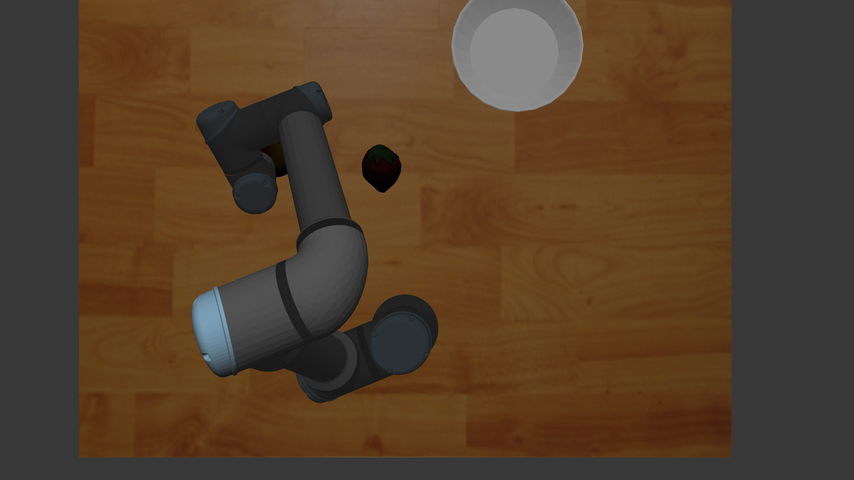

In [3]:
resize_image('Robot_Arm_Data/dark_default_cam/image_20250325_223301_0.png')

In [7]:
inference(model=model, tokenizer=processor, temperature=1.5, min_p=0.1, return_value=False,
          system_message=system_message,
          image_path='Robot_Arm_Data/dark_default_cam/image_20250325_222612_1.png',
          prompt='Something cold and fizzy would go well with my meal.<camera>0.5,-0.75,1.8</camera>')

<obj>coke_can</obj> <pose>0.715,-0.16,0.72</pose> <orient>0.37508,0.92699,-0.00045,0.00284</orient><|im_end|>


In [ ]:
conversation = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "You are a helpful assistant."}],
        },
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : "Hi, can you help me with something?"},]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : "Sure! what can I help you with?"} ]
        },
        
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : sample['prompt']},
            {"type" : "image", "image" : Image.open(sample["images"]).resize((854, 480)).convert('RGB')} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["output"]} ]
        }
    ]